# PART-2 (Panorama)

## Having sound knowledge on mathematical techniques that involve linear algebra are essential for succeeding in the discipline of Computer Vision. Now that we have established your abilities as an aspiring OpenCV developer, it's better that you implement all the functionalities on your own without using the library functions.

#### Do not use any OpenCV function for this part. You've to implement a total of 2 tasks for this part. Task 3 is a bonus for undergrad and mandatory for MS/EE. Task 4 is a bonus task for everyone. Don't copy code from google.

In [1]:
import munkres
import numpy as np
from skimage import color
import cv2
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
%matplotlib notebook


## Task 1

### Just as you implemented feature point detection in previous part, one possible way to detect features is to use a corner point detector. Your job is to implement a corner point detector(KLT or Harris Corner Detector).

### Input of this task is an image and you have to return a list containing the detected corners for the given image. Do not forget to visualize the detected points. 

#### Hint : For KLT you can do the following: 1) Smooth the image using a guassian mask (see derivative of gaussian function on google). 2) Make two derivative filters in x and y direction and convolve the image using those filters. 3) Convolve the image using a window of appropriate size and find the two eigen values of covariance matrix for each point. If ratio of max(eigenvalue) and min(eigenvalue) is greater than a certain threshold, this point can be a corner point. 4) Apply the non-maxima suppression to avoid using points that are too close to each other. 
#### Hint : Harris Corner Detector has been covered in class and much of the code is same for both corner detectors.


In [2]:
def windows(x,y,window_size,Ixx,Iyy,Ixy):
    return Ixx[y-window_size:y+window_size+1,x-window_size:x+window_size+1],Iyy[y-window_size:y+window_size+1,x-window_size:x+window_size+1],Ixy[y-window_size:y+window_size+1,x-window_size:x+window_size+1]
    
def HarrisCD(image):
    #First calculate gradients in both x and y directions
    dy,dx = np.gradient(image)
    row,col = image.shape
    window_size = 10
    k = 0.04
    Ixx = np.square(dx)
    Iyy = np.square(dy)
    Ixy = dx*dy
    pts = []
    xlist,ylist = [],[]
    threshold = 0 
    for y in range(window_size,row-window_size):
        for x in range(window_size, col - window_size):
            wIxx,wIyy,wIyx = windows(x,y,window_size,Ixx,Iyy,Ixy)
            
            sxx = wIxx.sum()
            syy = wIyy.sum()
            syx = wIyx.sum()
            
            det = (sxx * syy) - (syx**2)
            trace = sxx + syy
            r = det - k*(trace**2)
            
            if r > 1:
                xlist.append(x)
                ylist.append(y)
                
                
    rx,ry = [],[]
    for i in range(len(xlist)):
        if i % (len(xlist)//100) == 0:
            rx.append(xlist[i])
            ry.append(ylist[i])
    return rx,ry
    

(864, 1152)
101


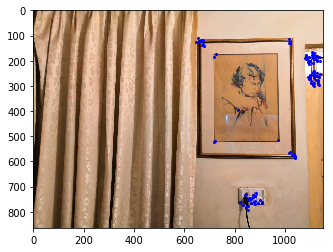

In [3]:
## Write Code Here
left = mpimg.imread('left_2.jpeg')
right = mpimg.imread('right_2.jpeg')
leftgray = np.array(color.rgb2gray(left))
rightgray = np.array(color.rgb2gray(right))

print(leftgray.shape)
x1,y1 = HarrisCD(leftgray)
# print(pts)
plt.imshow(left)
print(len(x1))
plt.plot(x1,y1,'bo', markersize=2)
plt.show()



101


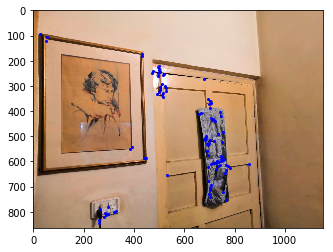

In [4]:
x2,y2 = HarrisCD(rightgray)
# print(pts)
plt.imshow(right)
print(len(x2))
plt.plot(x2,y2,'bo', markersize=2)
plt.show()

## Task 2

### Now match the detected points using some cost metric e.g. norm between detected points (You were asked to take two images by rotating the camera so the best match would be the points having least distance between them.)

### The input for this task is the detected corner points of two images that we want to stitch together. The return value must be a tuple of two lists of image points that have been matched (matchedpoints_img1 , matchedpoints_img2). Keep in mind that first point in matchedpoints_img1 is matched to the first point in matchedpoints_img2 so the length of both lists must be same. Do not forget to visualize the matched points in both images side by side.

#### Hint : Make a cost matrix having cost of joining each point of image 1 with all points of image 2. Pass this cost matrix to Hungarian Function (munkres) and it will be returning the matched points so that the overall cost is minimized. See the documentation of munkres in python and use 'pip install munkres' to use this module.

In [5]:
def ED(point1, point2):
    x1,y1 = point1
    x2,y2 = point2
    diff_x = x1-x2
    diff_y = y1-y2
    
    diff_x = diff_x**2
    diff_y = diff_y**2
    
    ed = np.sqrt(diff_x + diff_y)
    return ed

In [6]:
def matching(fimg1,fimg2):
    cost_matrix = []
    costperpoint= []
    for ptimg1 in fimg1:
        for ptimg2 in fimg2:
            cost = ED(ptimg1,ptimg2)
            costperpoint.append(cost)
        cost_matrix.append(costperpoint)
        costperpoint = []
    
    return np.array(cost_matrix)
    
        
pts1 = list(zip(x1,y1))
pts2 = list(zip(x2,y2))

costmatrix = matching(pts1,pts2)

In [7]:
print(costmatrix.shape)



(101, 101)


In [8]:
from munkres import Munkres, print_matrix
# Help from: http://software.clapper.org/munkres/

In [9]:
m = Munkres()
indexes = m.compute(costmatrix)
print("X")


X


101


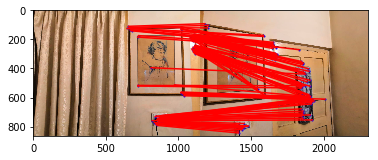

In [10]:

img1=[]
img2=[]
for m,n in indexes:
    if costmatrix[m][n] == 0:
        img1.append(pts1[m])
        img2.append(pts2[n])
        
dst = np.zeros((max(left.shape[0],right.shape[0]),left.shape[1]+right.shape[1],3))
for y in range(left.shape[0]):
    for x in range(left.shape[1]):
        dst[y,x] = left[y,x]/255
for y in range(right.shape[0]):
    for x in range(right.shape[1]):
        dst[y,x+left.shape[1]] = right[y,x]/255        

x1 = [i[0] for i in img1]
y1 = [i[1] for i in img1]
print(len(x1))
plt.plot(x1,y1,'bo', markersize=1)    
# plt.show()

x2 = [i[0]+left.shape[1] for i in img2]
y2 = [i[1] for i in img2]
plt.imshow(dst)
plt.plot(x2,y2,'bo', markersize=1) 
for i in range(len(x1)):
    plt.plot([x1[i],x2[i]],[y1[i],y2[i]],"-",color="r")
plt.show()

## Task 3 [Bonus/MS/EE]

### Now we want to find the best homography between these matched points. You have to implement RANSAC algorithm for this task. 

### Input for this task is the output from previous task i.e. (matchedpoints_img1 , matchedpoints_img2). The return value for this task would be the best homography that you found.

#### Hint : Remember that we need at least 4 points to estimate homography. You can use 2dhomography function that you implemented in previous assignmnets. Randomly select 4 points in each iteration. Compute homography using these 4 points and apply this homography to the set of matchedpoints_img1 to see how much close they get to matchedpoints_img2. You can use the norm function to get the cost and select the homography for which the cost was minimum.

In [ ]:
## Write Code Here

## Task 4 [Bonus]

### Finally, apply the homography from previous section to get the transformed image and stitch the two images together to make a panorama.

### Input for this task are two images. Apply all functions you implmented in previous tasks and return a stitched panorama image.

#### Hint : Add padding to the first array and copy contents of transformed second image into this padded image to get the stitched image. Choose the vertical line	in the middle as the stitching line. You have done warping in programming assignment 1 so use that knowledge to crack this part.

In [ ]:
## Write Code Here